In [1]:
### ARCHITECTURE SEARCH : averaging psychophysical results across architectures ###
import sys
import os
import json
import numpy as np
import glob
import copy
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import util_human_model_comparison
import util_psychophysics_figures


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value


### Specify scope of all models to compare (regex must grab all model output directories)
regex_model_dir = '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_*/'
basename_valid_metrics = 'validation_metrics.json'
basename_arch_config = 'brain_arch.json'

### Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_MistunedHarm_v00_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_AltPhase_v01_bestckpt_results_dict.json',
}
for key in experiment_to_basename_map.keys():
    experiment_to_basename_map[key] = experiment_to_basename_map[key].replace('EVAL_', 'EVAL_SOFTMAX_')

experiment_keys = [
    'bernox2005',
    'transposedtones',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'altphasecomplexes'
]
list_valid_metric = []
list_model_dir = []
disp_step = 100

for idx, model_dir in enumerate(sorted(glob.glob(regex_model_dir))):
    fn_valid_metric = os.path.join(model_dir, basename_valid_metrics)
    fn_arch_config = os.path.join(model_dir, basename_arch_config)
    fn_result_dict = {}
    for ek in experiment_keys:
        fn_result_dict[ek] = os.path.join(model_dir, experiment_to_basename_map[ek])
    
    include_model_flag = True
    if not os.path.exists(fn_arch_config): include_model_flag = False
    if not os.path.exists(fn_valid_metric): include_model_flag = False
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False 
    
    if include_model_flag:
        list_model_dir.append(model_dir)
        list_valid_metric.append(calc_best_metric(fn_valid_metric))
    
    if idx % disp_step == 0:
        print(model_dir, include_model_flag)

print('Number of successfully architectures:', len(list_valid_metric))


/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0000/ False
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0100/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0200/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0300/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0400/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0500/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0600/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0700/ False
Number of successfully architectures: 548


In [2]:
importlib.reload(util_psychophysics_figures)
importlib.reload(util_human_model_comparison)

sort_idx = np.argsort(list_valid_metric)
sorted_list_valid_metric = np.array(list_valid_metric)[sort_idx]
sorted_list_model_dir = np.array(list_model_dir)[sort_idx]
top_model_dirs = sorted_list_model_dir[-20:]

experiment_to_plot_fcn_map = {
    'bernox2005': util_psychophysics_figures.make_bernox_threshold_plot,
    'transposedtones': util_psychophysics_figures.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_psychophysics_figures.make_freqshiftedcomplexes_plot,
    'mistunedharmonics': util_psychophysics_figures.make_mistuned_harmonics_bar_graph,
    'altphasecomplexes': util_psychophysics_figures.make_altphase_plot,
}

top_model_results_dicts = {key: [] for key in experiment_keys}
for key in experiment_keys:
    for model_dir in top_model_dirs:
        results_dict_fn = os.path.join(model_dir, experiment_to_basename_map[key])
        with open(results_dict_fn) as f:
            top_model_results_dicts[key].append(json.load(f))

results_dicts = top_model_results_dicts

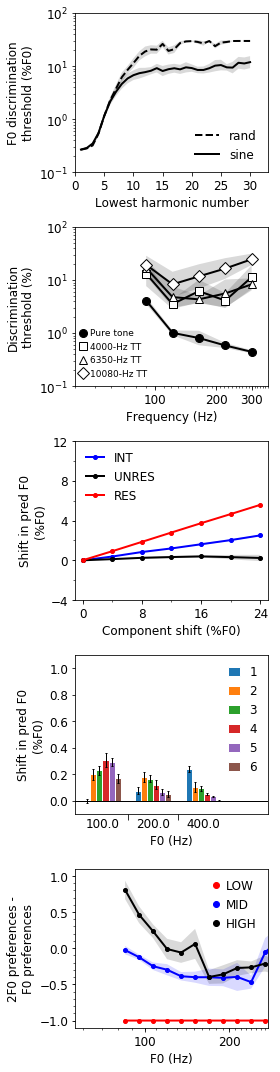

In [3]:
NROWS = len(experiment_keys)
NCOLS = 1
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))

for ax_idx, key in enumerate(experiment_keys):
    plot_fcn = experiment_to_plot_fcn_map[key]
    kwargs = {
        'include_yerr': True,
        'kwargs_bootstrap': {
            'bootstrap_repeats': 1000,
            'metric_function': 'median',
        },
    }
    if ('bernox' in key) or ('transposed' in key):
        kwargs['threshold_cap'] = 30
    if ('freqshifted' in key) or ('mistuned' in key):
        kwargs['use_relative_shift'] = True
    plot_fcn(ax[ax_idx], results_dicts[key], **kwargs)

plt.tight_layout()
plt.show()

# fig, ax = util_psychophysics_figures.make_altphase_histograms(top_model_results_dicts['altphasecomplexes'])
# plt.show()

In [24]:
### GENERIC PARAMETERS
figsize=(4,3)
poster_plot_kwargs = {
    'fontsize_labels': 16,
    'fontsize_legend': 14,
    'fontsize_ticks': 15,
    'include_yerr': True,
    'kwargs_bootstrap': {
        'bootstrap_repeats': 1000,
        'metric_function': 'median',
    },
}

### Build dictionary of human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

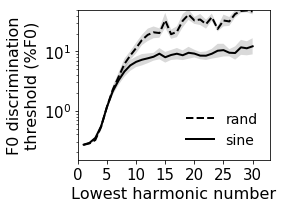

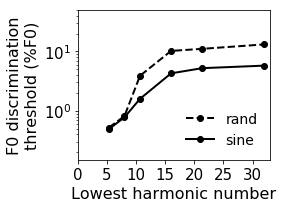

In [25]:
### bernox2005 discrimination threholds

importlib.reload(util_psychophysics_figures)
importlib.reload(util_human_model_comparison)
plot_fcn = util_psychophysics_figures.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['xlimits'] = [0, 33]
kwargs['ylimits'] = [0.15, 50]
kwargs['threshold_cap'] = 50

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['bernox2005'], **kwargs)
plt.tight_layout()

# PLOT HUMAN
sine_plot_kwargs={'marker': '.', 'ms':12}
rand_plot_kwargs={'marker': '.', 'ms':12}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs,
         sine_plot_kwargs=sine_plot_kwargs,
         rand_plot_kwargs=rand_plot_kwargs)
plt.tight_layout()

plt.show()

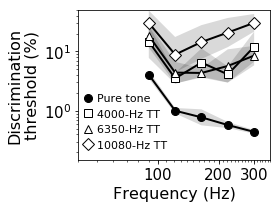

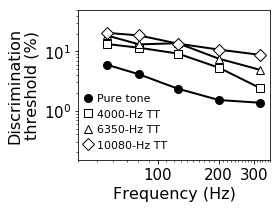

In [26]:
### transposed tones discrimination thresholds

importlib.reload(util_psychophysics_figures)
importlib.reload(util_human_model_comparison)
plot_fcn = util_psychophysics_figures.make_TT_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_transposedtones()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['fontsize_legend'] = 11
kwargs['xlimits'] = [40, 360]
kwargs['ylimits'] = [0.15, 50]
kwargs['threshold_cap'] = 50

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['transposedtones'], **kwargs)
plt.tight_layout()

# PLOT HUMAN
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs)
plt.tight_layout()

plt.show()

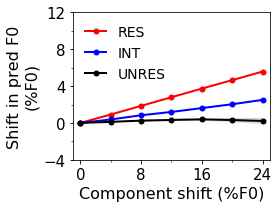

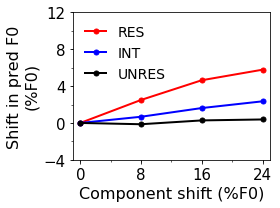

In [87]:
### frequency shifted complexes

importlib.reload(util_psychophysics_figures)
importlib.reload(util_human_model_comparison)
plot_fcn = util_psychophysics_figures.make_freqshiftedcomplexes_plot
human_rd = util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['restrict_conditions'] = ['5', '11', '16']
kwargs['cmap_name'] = ['r', 'b', 'k']#'Dark2'

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['freqshiftedcomplexes'], **kwargs, use_relative_shift=True)
plt.tight_layout()

# PLOT HUMAN
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs, use_relative_shift=True)
plt.tight_layout()

plt.show()

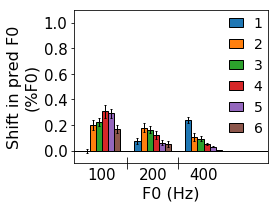

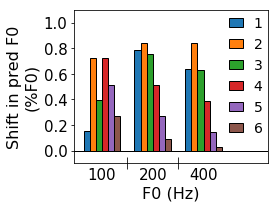

In [94]:
### mistuned harmonics bar graph

importlib.reload(util_psychophysics_figures)
importlib.reload(util_human_model_comparison)
plot_fcn = util_psychophysics_figures.make_mistuned_harmonics_bar_graph
human_rd = util_human_model_comparison.get_human_results_dict_mistunedharmonics()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['cmap_name'] = 'tab10'

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['mistunedharmonics'], **kwargs, use_relative_shift=True)
plt.tight_layout()

# PLOT HUMAN
kwargs_human = copy.deepcopy(kwargs)
kwargs_human['include_yerr'] = False
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs_human, use_relative_shift=True)
plt.tight_layout()

plt.show()

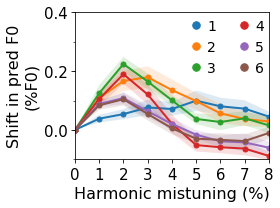

In [122]:
### mistuned harmonics line plot

importlib.reload(util_psychophysics_figures)
importlib.reload(util_human_model_comparison)
plot_fcn = util_psychophysics_figures.make_mistuned_harmonics_line_plot
human_rd = util_human_model_comparison.get_human_results_dict_mistunedharmonics()

kwargs = copy.deepcopy(poster_plot_kwargs)
# kwargs['cmap_name'] = 'Accent'
kwargs['ylimits'] = [-0.1, 0.4]
kwargs['yticks'] = 0.2

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['mistunedharmonics'], **kwargs, use_relative_shift=True)
plt.tight_layout()


plt.show()

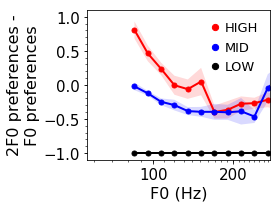

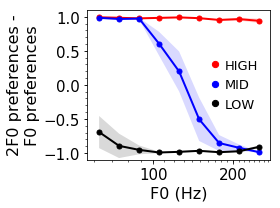

In [118]:
### alt phase line plot

importlib.reload(util_psychophysics_figures)
importlib.reload(util_human_model_comparison)
plot_fcn = util_psychophysics_figures.make_altphase_plot
human_rd = util_human_model_comparison.get_human_results_dict_altphasecomplexes(average_conditions=False)

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['fontsize_legend'] = 13

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['altphasecomplexes'], **kwargs)
plt.tight_layout()

# PLOT HUMAN
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs)
plt.tight_layout()

plt.show()

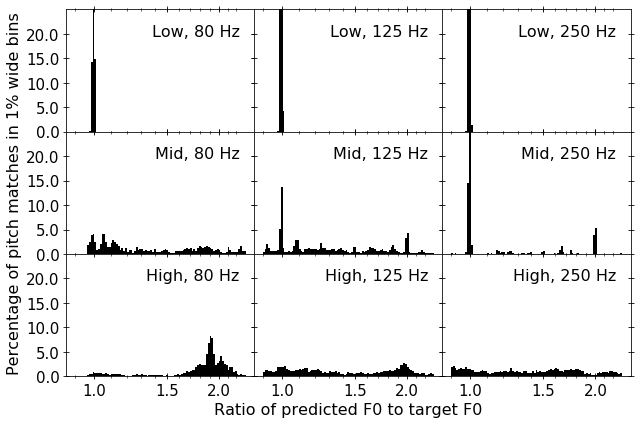

In [125]:
### altphase histograms

importlib.reload(util_psychophysics_figures)
importlib.reload(util_human_model_comparison)

# PLOT MODEL
fig, ax = util_psychophysics_figures.make_altphase_histograms(results_dicts['altphasecomplexes'],
                                                              bin_step=0.01,
                                                              figsize=(9,6),
                                                              fontsize_labels=16,
                                                              fontsize_legend=16,
                                                              fontsize_ticks=15,
                                                              xticks=[1.0, 1.5, 2.0],
                                                              xlimits=[0.9, 2.3],
                                                              yticks=5,
                                                              ylimits=[0, 25],
                                                              condition_plot_labels={})


plt.show()